In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/shanmugapriyan/Downloads/csv_preprocessed.csv')

In [3]:
data['Attack Type'] = data['Attack Type'].apply(lambda x: 0 if x == 0 else 1)

In [4]:
X = data.drop(columns=["Attack Type"])

In [5]:
Y = data["Attack Type"]

In [6]:
def mutual_info(X, Y):
  mutual_info_arr = mutual_info_classif(X, Y)
  series_info = pd.Series(mutual_info_arr)
  series_info.index = X.columns
  series_top = series_info.sort_values(ascending=False)[:25]
  return series_top

<Axes: >

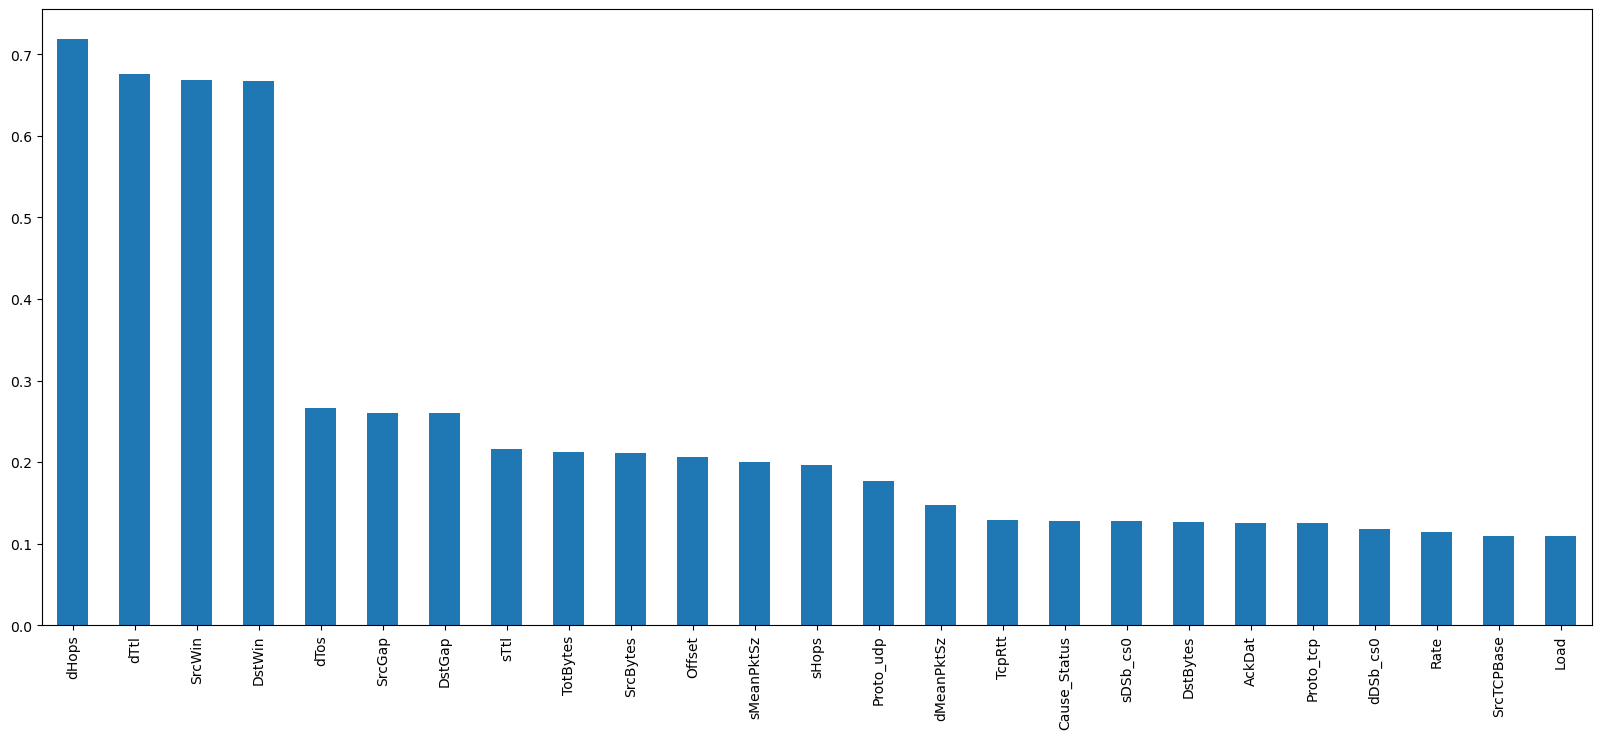

In [7]:
result = mutual_info(X, Y)
result.plot.bar(figsize=(20,8))

In [8]:
new_data = data[result.keys()]
new_data.head()

,dHops,dTtl,SrcWin,DstWin,dTos,SrcGap,DstGap,sTtl,TotBytes,SrcBytes,...,TcpRtt,Cause_Status,sDSb_cs0,DstBytes,AckDat,Proto_tcp,dDSb_cs0,Rate,SrcTCPBase,Load
0,-0.973059,-0.00732,3.442533e-07,6.217791e-08,-0.094739,-0.00383,-0.006334,-0.419379,-0.117591,-0.099523,...,-0.267969,0.0,1.0,-0.066388,-0.388062,0.0,1.0,-0.010846,3.187841e-12,-0.008291
1,-0.973059,-0.00732,3.442533e-07,6.217791e-08,-0.094739,-0.00383,-0.006334,-0.419379,-0.117591,-0.099523,...,-0.267969,0.0,1.0,-0.066388,-0.388062,0.0,1.0,-0.010846,3.187841e-12,-0.008291
2,-0.973059,-0.00732,3.442533e-07,6.217791e-08,-0.094739,-0.00383,-0.006334,0.635573,8.131316,9.877388,...,-0.267969,0.0,1.0,0.224388,-0.388062,0.0,1.0,-0.010347,3.187841e-12,-0.007624
3,-0.973059,-0.00732,3.442533e-07,6.217791e-08,-0.094739,-0.00383,-0.006334,0.635573,7.224216,8.734380,...,-0.267969,0.0,1.0,0.259298,-0.388062,0.0,1.0,-0.010417,3.187841e-12,-0.007698
4,-0.973059,-0.00732,3.442533e-07,6.217791e-08,-0.094739,-0.00383,-0.006334,0.635573,9.162383,11.165238,...,-0.267969,0.0,1.0,0.201274,-0.388062,0.0,1.0,-0.010326,3.187841e-12,-0.007541


In [9]:
# # Hard coding now to skip the mutual information step
# new_data = data[["SrcWin", "DstWin", "dHops", "dTtl", "TotBytes", "SrcBytes", "sMeanPktSz", "DstGap", "SrcGap", "dTos", "DstTCPBase", "SrcTCPBase", "TcpRtt", "Proto_udp", "DstBytes", "AckDat" , "dMeanPktSz", "Proto_tcp", "SynAck", "Load"]]
# new_data.head()

In [10]:
def concat_column_for_plot(pca_data, column_name):
  for_plot = pd.concat([pca_data, data[column_name]], axis = 1)
  return for_plot

In [11]:
new_data = concat_column_for_plot(new_data, "Attack Type")

In [12]:
X_train, X_test, y_train, y_test = train_test_split(new_data.loc[:, new_data.columns != 'Attack Type'], new_data['Attack Type'],
                                                    stratify=new_data['Attack Type'],
                                                    test_size=0.15)

X_train = pd.DataFrame(X_train, columns=new_data.columns.to_list()[:-1])
X_test = pd.DataFrame(X_test, columns=new_data.columns.to_list()[:-1])
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1033323, 25)
Testing dataset size: (182352, 25)
Training target size: (1033323, 1)
Testing target size: (182352, 1)


In [13]:
def get_pca_df(scaled_data, no_of_components):
  pca = PCA(n_components=no_of_components)
  Principal_components=pca.fit_transform(scaled_data)
  column_names = ["PC "+str(i) for i in range(1, no_of_components+1)]
  pca_df = pd.DataFrame(data = Principal_components, columns = column_names)
  return pca_df, pca

In [14]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
Y = new_data['Attack Type']
X_train, pca = get_pca_df(X_train, 15)
for train_index, test_index in skf.split(X_train, y_train):
    X1_train, X1_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y1_train, y1_test = y_train.iloc[train_index], y_train.iloc[test_index]
    # Initialize kNN classifier
    knn = KNeighborsClassifier(n_neighbors=19)
    # Train the classifier
    knn.fit(X1_train, y1_train)
    # Predict on the test set
    y_pred = knn.predict(X1_test)
    # Calculate evaluation metrics and store them
    accuracy_scores.append(accuracy_score(y1_test, y_pred))
    precision_scores.append(precision_score(y1_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y1_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y1_test, y_pred, average='weighted'))

In [16]:
x_test = pca.transform(X_test)


In [17]:
x_test

array([[-1.23682909,  0.48421527, -0.59311118, ..., -0.05763695,
        -0.41306279, -0.07595246],
       [-0.40910712, -0.02257485,  0.01463883, ...,  0.17110147,
         0.4839163 ,  0.22465804],
       [-0.61577818,  0.04796014, -0.1521668 , ...,  0.09939608,
         0.10858872,  0.03870769],
       ...,
       [-0.33172892, -0.02610058,  0.10891376, ...,  0.07659166,
         0.63894336,  0.50711237],
       [-0.51178972,  1.61506688,  0.76676694, ..., -0.26650301,
         0.55377405, -0.25879287],
       [-0.80055062,  1.7157725 ,  0.53174986, ..., -0.36675048,
         0.02671926, -0.5203409 ]])

In [18]:
y1_pred = knn.predict(x_test)

In [19]:
accuracy_score(y_test, y1_pred)

0.9997532245327718

In [20]:
accuracy_scores

[0.9997870950572182,
 0.9997822563085186,
 0.9998064500520165,
 0.9997967715712461,
 0.9998112878875857]

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
# Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y1_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[ 71585     44]
 [     1 110722]]


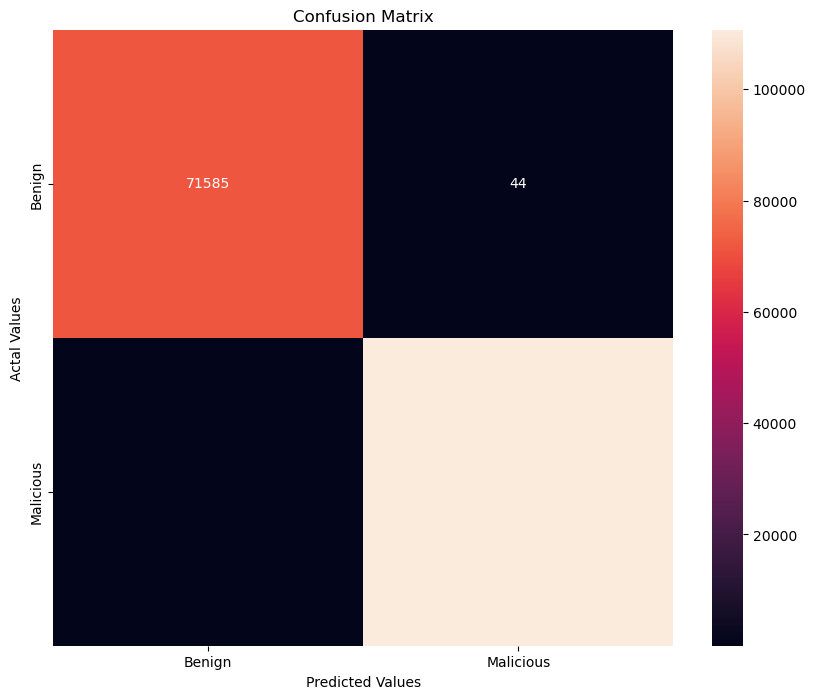

In [24]:
import seaborn as sns
le_name_mapping = {'Benign': 0, 'Malicious': 1}

from sklearn.metrics import confusion_matrix

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y1_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = le_name_mapping.keys(), 
                     columns = le_name_mapping.keys())

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [25]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y1_pred, average='weighted') # Use 'binary' for binary classification
print(f'Precision: {precision}')

Precision: 0.9997533149095027


In [26]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y1_pred, average='weighted') # Use 'binary' for binary classification
print(f'Recall: {recall}')

Recall: 0.9997532245327718


In [27]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y1_pred, average='weighted') # Use 'binary' for binary classification
print(f'F1 Score: {f1}')

F1 Score: 0.9997532114404309


In [28]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y1_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9997532245327718


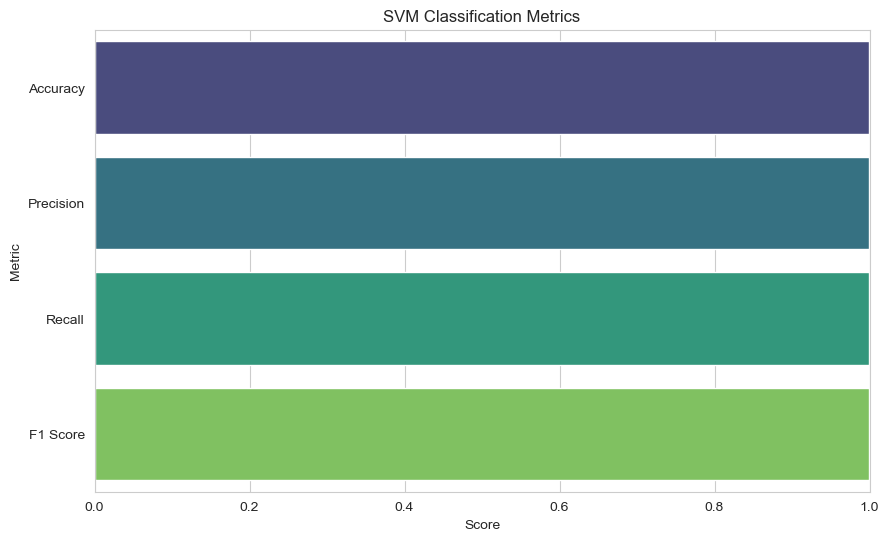

In [29]:
import matplotlib.pyplot as plt


# Assuming metrics are stored in these variables
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    # 'ROC-AUC': roc_auc  # Uncomment if ROC-AUC is applicable and calculated
}

# Convert dictionary to lists for plotting
metric_names = list(metrics.keys())
metric_values = [metrics[metric] for metric in metric_names]

# Create bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_values, y=metric_names, palette="viridis")

plt.xlabel('Score')
plt.ylabel('Metric')
plt.title('SVM Classification Metrics')
plt.xlim(0, 1)  # Assuming the scores are between 0 and 1
plt.show()